# 第15章 自然语言处理：应用

## 15.1 情感分析及数据集

### 练习15.1.1

我们可以修改本节中的哪些超参数来加速训练情感分析模型？

**解答：**

### 练习15.1.2

请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。

**解答：**

## 15.2 情感分析：使用循环神经网络

### 练习15.2.1

增加迭代轮数可以提高训练和测试的准确性吗？调优其他超参数怎么样？

**解答：**

### 练习15.2.2

使用较大的预训练词向量，例如300维的GloVe嵌入。它是否提高了分类精度？

**解答：**

### 练习15.2.3

&emsp;&emsp;是否可以通过spaCy词元化来提高分类精度？需要安装Spacy（`pip install spacy`）和英语语言包（`python -m spacy download en`）。在代码中，首先导入Spacy（`import spacy`）。然后，加载Spacy英语软件包（`spacy_en = spacy.load('en')`）。最后，定义函数`def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]`并替换原来的`tokenizer`函数。请注意GloVe和spaCy中短语标记的不同形式。例如，短语标记“new york”在GloVe中的形式是“new-york”，而在spaCy词元化之后的形式是“new york”。

**解答：**

## 15.3 情感分析：使用卷积神经网络

### 练习15.3.1

调整超参数，并比较15.2节中用于情感分析的架构和本节中用于情感分析的架构，例如在分类精度和计算效率方面。

**解答：**

### 练习15.3.2

请试着用15.2节练习中介绍的方法进一步提高模型的分类精度。

**解答：**

### 练习15.3.3        

在输入表示中添加位置编码。它是否提高了分类的精度？

**解答：**

## 15.4 自然语言推断与数据集

### 练习15.4.1

机器翻译长期以来一直是基于翻译输出和翻译真实值之间的表面$n$元语法匹配来进行评估的。可以设计一种用自然语言推断来评价机器翻译结果的方法吗？

**解答：**

### 练习15.4.2

我们如何更改超参数以减小词表大小？

**解答：**

## 15.5 自然语言推断：使用注意力

### 练习15.5.1

使用其他超参数组合训练模型，能在测试集上获得更高的准确度吗？

**解答：**

&emsp; &emsp; 通过调节超参数组合，将所得的结果整理如下：

| batch_size | num_steps | learning rate | num_epochs | result |
|:--:|:--:|:--:|:--:|:--:|
| 256 | 50 | 0.001  | 4 | loss 0.495, train acc 0.806, test acc 0.826 |
| 256 | 50 | 0.0003 | 4 | loss 0.547, train acc 0.780, test acc 0.810 |
| 256 | 50 | 0.003  | 4 | loss 0.631, train acc 0.740, test acc 0.752 |
| 256 | 50 | 0.001  | 6 | loss 0.462, train acc 0.820, test acc 0.829 |
| 256 | 50 | 0.001  | 8 | **loss 0.441, train acc 0.830, test acc 0.834** |
| 128 | 50 | 0.001  | 8 | loss 0.448, train acc 0.827, test acc 0.828 |
| 512 | 50 | 0.001  | 8 | **loss 0.440, train acc 0.829, test acc 0.834** |

从表格可以看出，超参数组合 `batch_size = 512/256 num_steps = 50  learning rate = 0.001  num_epochs = 8`，测试集精度最好,可达到83.4%。

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [4]:
# 注意
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B的形状：（批量大小，序列A/B的词元数，embed_size）
        # f_A/f_B的形状：（批量大小，序列A/B的词元数，num_hiddens）
        f_A = self.f(A)
        f_B = self.f(B)
        # e的形状：（批量大小，序列A的词元数，序列B的词元数）
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # beta的形状：（批量大小，序列A的词元数，embed_size），
        # 意味着序列B被软对齐到序列A的每个词元(beta的第1个维度)
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # beta的形状：（批量大小，序列B的词元数，embed_size），
        # 意味着序列A被软对齐到序列B的每个词元(alpha的第1个维度)
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha
    
# 比较
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B
    
# 聚合
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # 对两组比较向量分别求和
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # 将两个求和结果的连结送到多层感知机中
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [5]:
# 定义可分解注意力模型
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 有3种可能的输出：蕴涵、矛盾和中性
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

loss 0.495, train acc 0.806, test acc 0.826
14133.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


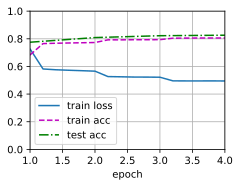

In [14]:
# 读取数据集
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.441, train acc 0.830, test acc 0.834
14859.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


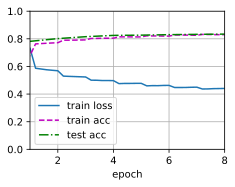

In [15]:
# 读取数据集
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.440, train acc 0.829, test acc 0.834
22247.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


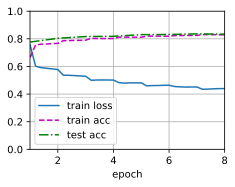

In [8]:
# 读取数据集
batch_size, num_steps = 512, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 练习15.5.2

自然语言推断的可分解注意模型的主要缺点是什么？

**解答：**

### 练习15.5.3

假设我们想要获得任何一对句子的语义相似级别（例如，0～1之间的连续值）。我们应该如何收集和标注数据集？请尝试设计一个有注意力机制的模型。

**解答：**

## 15.6 针对序列级和词元级应用微调BERT

### 练习15.6.1

让我们为新闻文章设计一个搜索引擎算法。当系统接收到查询（例如，“冠状病毒爆发期间的石油行业”）时，它应该返回与该查询最相关的新闻文章的排序列表。假设我们有一个巨大的新闻文章池和大量的查询。为了简化问题，假设为每个查询标记了最相关的文章。如何在算法设计中应用负采样（见14.2.1节）和BERT？

**解答：**

### 练习15.6.2        

我们如何利用BERT来训练语言模型？

**解答：**

### 练习15.6.3

我们能在机器翻译中利用BERT吗？

**解答：**

## 15.7 自然语言推断：微调BERT

### 练习15.7.1

&emsp;&emsp;如果您的计算资源允许，请微调一个更大的预训练BERT模型，该模型与原始的BERT基础模型一样大。修改`load_pretrained_model`函数中的参数设置：将“bert.small”替换为“bert.base”，将`num_hiddens=256`、`ffn_num_hiddens=512`、`num_heads=4`和`num_layers=2`的值分别增加到768、3072、12和12。通过增加微调迭代轮数（可能还会调优其他超参数），你可以获得高于0.86的测试精度吗？

**解答：**

### 练习15.7.2

如何根据一对序列的长度比值截断它们？将此对截断方法与`SNLIBERTDataset`类中使用的方法进行比较。它们的利弊各是什么？

**解答：**